In [1]:
from urllib.request import urlopen # used to open web pages
import requests
from bs4 import BeautifulSoup # parses html
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
from collections import defaultdict
import os
import datetime
import seaborn as sns

In [2]:
html = urlopen('http://web.mta.info/developers/turnstile.html') # open the html page
bs = BeautifulSoup(html, 'html.parser') # create a BS object from the page

In [3]:
# get a list of the file names on the website (we only use a subset: march - May 2019)
address_endings = []
for row in bs.find_all('a')[80:94]:
    address_endings.append(row['href'])

In [4]:
file_names = [s[-10:-4] for s in address_endings]

In [29]:
if not os.path.isdir("data"):
    os.mkdir("data")

In [31]:
# download all datasets to the data directory
address = 'http://web.mta.info/developers/' # base address
for i, name in enumerate(address_endings):
    if i%10 == 0:
        print('downloading file', i, ':', file_names[i])
    url = address+name # the full address
    r = requests.get(url)
    with open('data/'+file_names[i]+'.csv', 'wb') as f:
        f.write(r.content)

downloading file 0 : 190817
downloading file 10 : 190608


In [6]:
dfs = [] # list of dataframes, one for each file
not_loaded = []
for i, file_name in enumerate(os.listdir('data')):
    if i%25 == 0:
        print('loading dataframe', i)
    if file_name == '.DS_Store': # sometimes these files appear in mac folders, skip them
        continue
    try:
        df = pd.read_csv('data/'+file_name, header=0)
        dfs.append(df)
    except:
        print(file_name, 'could not be loaded')
        not_loaded.append(file_name)

loading dataframe 0


In [7]:
df = pd.concat(dfs)

In [8]:
# strip leading and trailing spaces from column names
df.columns = map(lambda s: s.strip(), df.columns)

## Cleaning/ analysis

In [9]:
# add DATETIME column
dt_vals = df[['DATE', 'TIME']].values
dt_vals = [dt_val[0]+' '+dt_val[1] for dt_val in dt_vals]
df['DATETIME'] = [datetime.datetime.strptime(dt, '%m/%d/%Y %H:%M:%S') for dt in dt_vals]

In [10]:
# get the total entries for each turnstile for each day
entries = df.groupby(['STATION', 'C/A', 'UNIT', 'SCP', 'DATE'], as_index=False).ENTRIES.agg(lambda l: max(l) - min(l))

In [11]:
# Remove outliers from the data (large numbers from turnstile counts reset midway through the day)
entries = entries[entries.ENTRIES < 1_000_000]

In [12]:
# get total traffic for each station
station_entries = entries.groupby(['STATION'], as_index=False).ENTRIES.sum()

In [13]:
stn_srt = station_entries.sort_values('ENTRIES', ascending=False)

In [14]:
start_date = df.DATETIME.min().strftime('%m/%d/%y')
end_date = df.DATETIME.max().strftime('%m/%d/%y')

In [15]:
# https://stackoverflow.com/a/60917129
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

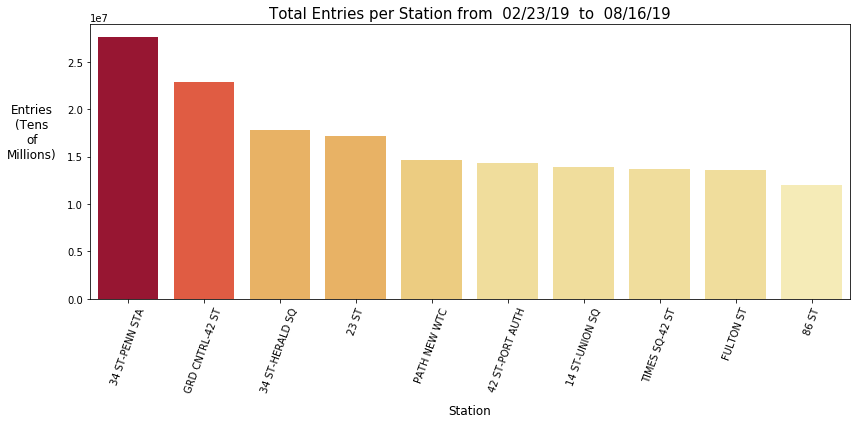

In [16]:
plt.figure(figsize=(12,6))
sns.barplot(x='STATION', y='ENTRIES', data=stn_srt.head(10), 
            palette=colors_from_values(stn_srt.head(10).ENTRIES, "YlOrRd"))
plt.title('Total Entries per Station from  {}  to  {}'.format(start_date, end_date), fontsize=15)
plt.xticks(rotation=70)
plt.xlabel('Station', labelpad=10, fontsize=12)
plt.ylabel('Entries\n(Tens\nof\nMillions)', rotation=0, labelpad=35, fontsize=12)
plt.tight_layout();
# plt.savefig('initial_stations_bar.png', dpi=300)

## Totals only for weekdays

In [17]:
# convert DATE column to datetime object
entries['DATE'] = entries.DATE.apply(lambda date: datetime.datetime.strptime(date, '%m/%d/%Y'))

In [18]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekdays_df = entries[entries.DATE.apply(lambda date: datetime.datetime.strftime(date, '%A') in weekdays)]

In [19]:
weekday_station_entries = weekdays_df.groupby(['STATION'], as_index=False).ENTRIES.sum()

In [20]:
weekday_station_entries

,STATION,ENTRIES
0,1 AV,2028077
1,103 ST,3527375
2,103 ST-CORONA,2360987
3,104 ST,569697
4,110 ST,1201186
...,...,...
374,WOODLAWN,794923
375,WORLD TRADE CTR,2558829
376,WTC-CORTLANDT,1669950
377,YORK ST,1467727


In [21]:
wkd_stn_srt = weekday_station_entries.sort_values('ENTRIES', ascending=False)

In [22]:
start = df.DATETIME.min().strftime('%m/%d/%y')
end = df.DATETIME.max().strftime('%m/%d/%y')

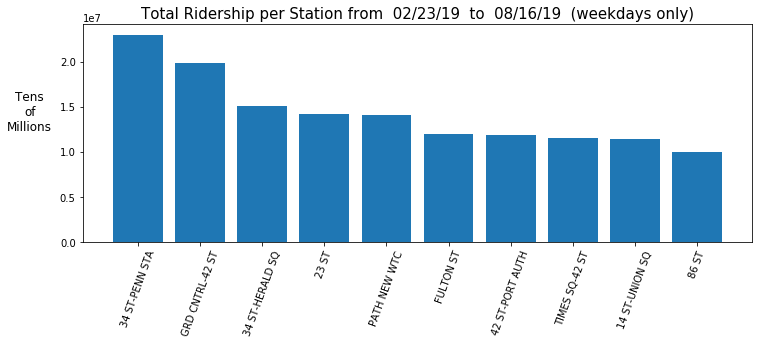

In [23]:
plt.figure(figsize=(12,4))
plt.bar(wkd_stn_srt.head(10).STATION, wkd_stn_srt.head(10).ENTRIES)
plt.title('Total Ridership per Station from  {}  to  {}  (weekdays only)'.format(start_date, end_date), fontsize=15)
plt.xticks(rotation=70);
plt.ylabel('Tens\nof\nMillions', rotation=0, labelpad=30, fontsize=12);

## Top ten stations

In [24]:
# stations narrowed down by using only weekday data, and visual inspection of proximity to tech companies

In [25]:
top = wkd_stn_srt.iloc[[0,1,2,3,5,6,7,11,16,17]]

## Pretty graphs

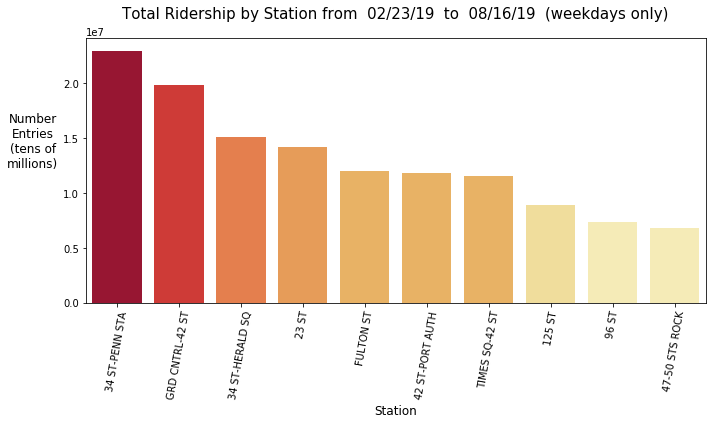

In [26]:
plt.figure(figsize=(10,6))
sns.barplot(x='STATION', y='ENTRIES', data=top, palette=colors_from_values(top.ENTRIES, "YlOrRd"))
plt.title('Total Ridership by Station from  {}  to  {}  (weekdays only)'.format(start, end), fontsize=15, pad=20)
plt.ylabel('Number\nEntries\n(tens of\nmillions)', rotation=0, labelpad=30, fontsize=12)
plt.xlabel('Station', fontsize=12)
plt.xticks(rotation=80);
plt.tight_layout()
# plt.savefig('stations_bar.png', dpi=300)